<a href="https://colab.research.google.com/github/Shahidazad/Pytorch/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and
#  learning the regularities or patterns in input data in such a way that the model can be used to generate 
# or output new examples that plausibly could have been drawn from the original dataset.


In [3]:
# discriminated model identify  the  example is imaginary  or the real example

In [4]:
# GANS generate the examples


In [5]:
import torch
import torchvision
from torchvision.transforms import ToTensor,Normalize,Compose
from torchvision.datasets import  MNIST


mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(),Normalize(mean=(0.5,),std= (0.5,))])) # convt to tensor ,normalize 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
# Note that we are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`.
#  The reason for doing this will become clear when define the generator network. Let's look at a sample tensor from the data.

In [7]:
# 1 is white and -1 is black
img,label = mnist[0]
print('Label',label)
print(img[:,10:15,10:15])
torch.min(img),torch.max(img)

Label 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [8]:
def denorm(x): # this function convert (-1, 1)  to (0 , 1)
  out = (x+1)/2
  return out.clamp(0,1)

Label: 5


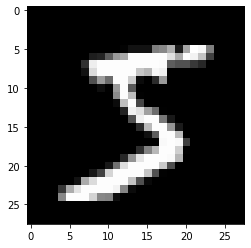

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
img_norm = denorm(img)
plt.imshow(img_norm[0],cmap = 'gray')
print('Label:',label)

In [10]:
from torch.utils.data import DataLoader # load data convt to 100 of batches

batch_size = 100
data_loader = DataLoader(mnist,batch_size,shuffle =True)

first batch 
torch.Size([100, 1, 28, 28])
tensor([7, 7, 6, 9, 6, 6, 5, 7, 8, 2, 3, 2, 9, 3, 3, 4, 7, 9, 0, 7, 7, 4, 9, 3,
        4, 2, 0, 8, 9, 8, 6, 3, 9, 8, 6, 0, 9, 7, 5, 4, 1, 6, 9, 5, 1, 6, 0, 1,
        8, 4, 2, 5, 6, 5, 4, 6, 3, 3, 8, 3, 2, 6, 8, 4, 7, 5, 4, 0, 1, 6, 7, 5,
        1, 9, 0, 9, 3, 7, 1, 2, 8, 9, 0, 1, 3, 9, 2, 7, 6, 8, 1, 3, 9, 7, 3, 9,
        3, 6, 0, 0])


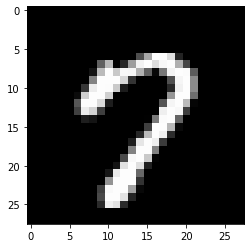

In [11]:
for img_batch,label_batch in data_loader:
  print('first batch ')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0],cmap='gray')
  print(label_batch)
  break

In [12]:
# device configuration
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cpu')

In [14]:
image_size = 784
hidden_size=256

In [15]:
# The discriminator takes an image as input, and tries to classify it as "real" or "generated".
#  In this sense, it's like any other neural network. While we can use a CNN for the discriminator
#  we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784

In [16]:
import torch.nn as nn
D= nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),  # relu ignore  -ve value but Leakyrelu multiple -ve value with 0.2 
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

In [17]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

Generator **Network**

In [18]:
latent_size = 64

In [19]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [20]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [21]:
y=G(torch.randn(2,latent_size))
y.reshape(-1,28,28).shape

torch.Size([2, 28, 28])

In [22]:
y=G(torch.randn(2,latent_size))
gen_imgs= denorm(y.reshape((-1,28,28)).detach()) # intrest only in value not in gradient 

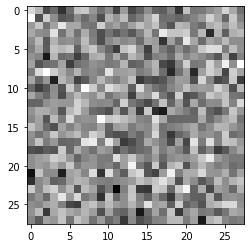

In [23]:
plt.imshow(gen_imgs[0],cmap='gray') # we have not train The generator it is randomised

In [24]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [25]:
## Discriminator Training

# Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify
#  how well it is able to differentiate between real and generated images.



In [26]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0002)# optimizer use gradient decent algorithms

g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002)

In [27]:
def  reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

In [28]:


def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [29]:
# I want to make the discriminator fool by generating flake images as a real images  generated by generator

In [30]:
def train_generator():
  # generate fake image and calculate loss
  z=torch.randn(batch_size,latent_size).to(device)
  fake_images =G(z)
  labels= torch.ones(batch_size,1).to(device)
  g_loss=criterion(D(fake_images),labels)

  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss,fake_images

# Train model

In [31]:
import os
sample_dir ='samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

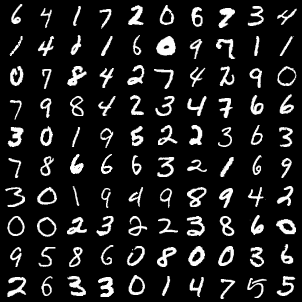

In [32]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


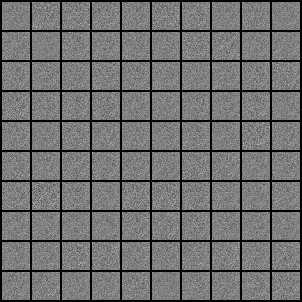

In [33]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [34]:
%%time

num_epochs = 40
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device) # 784 = -1 (28*28)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/40], Step [200/600], d_loss: 0.0522, g_loss: 4.0353, D(x): 0.99, D(G(z)): 0.04
Epoch [0/40], Step [400/600], d_loss: 0.0926, g_loss: 5.7320, D(x): 0.96, D(G(z)): 0.04
Epoch [0/40], Step [600/600], d_loss: 0.0302, g_loss: 5.5489, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/40], Step [200/600], d_loss: 0.0127, g_loss: 5.7754, D(x): 1.00, D(G(z)): 0.01
Epoch [1/40], Step [400/600], d_loss: 0.3313, g_loss: 3.4083, D(x): 0.89, D(G(z)): 0.14
Epoch [1/40], Step [600/600], d_loss: 0.2284, g_loss: 4.5535, D(x): 0.91, D(G(z)): 0.05
Saving fake_images-0002.png
Epoch [2/40], Step [200/600], d_loss: 0.0720, g_loss: 4.2013, D(x): 0.98, D(G(z)): 0.05
Epoch [2/40], Step [400/600], d_loss: 0.7404, g_loss: 4.9537, D(x): 0.91, D(G(z)): 0.40
Epoch [2/40], Step [600/600], d_loss: 0.1599, g_loss: 3.5864, D(x): 0.94, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/40], Step [200/600], d_loss: 0.8968, g_loss: 3.0159, D(x): 0.78, D(G(z)): 0.26
Epoch [3/40], Step [400/600], d_loss

In [35]:
# save model check point
torch.save(G.state_dict(),'G.ckpt')

torch.save(D.state_dict(),'D.ckpt')

In [36]:
Image('./samples/fake_images-003.png')

In [37]:
import cv2 # convert images to video  
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

Text(0.5, 1.0, 'Losses')

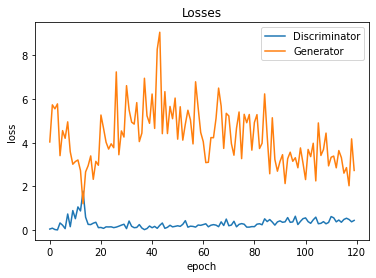

In [38]:
plt.plot(d_losses,'-')
plt.plot(g_losses,'-')# bring down the loss of generator
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

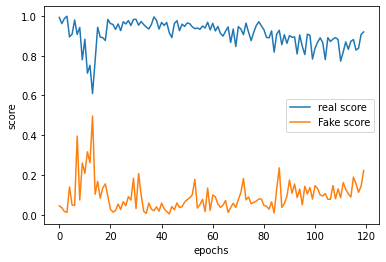

In [39]:
plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epochs')
plt.ylabel('score') # both should come closer and closer
plt.legend(['real score','Fake score'])
plt.title('Score')
